In [3]:
# Colab: install required packages
!pip install librosa soundfile noisereduce audiomentations tqdm --quiet
!pip install kagglehub --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 16.2 MB/s eta 0:00:00


# **imports**

In [4]:
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
import os
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

# augmentation + denoise
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import noisereduce as nr

In [5]:


# Download latest version of RAVDESS dataset
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

print("✅ Dataset downloaded at:", path)


Using Colab cache for faster access to the 'ravdess-emotional-speech-audio' dataset.
✅ Dataset downloaded at: /kaggle/input/ravdess-emotional-speech-audio


In [6]:


# Example: play one audio file
sample_file = os.path.join(path, "Actor_01", "03-01-05-01-01-01-01.wav")
ipd.Audio(sample_file)

In [7]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [8]:
# RAVDESS
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio -p ./data/ravdess --unzip

# CREMA-D
!kaggle datasets download -d ejlok1/cremad -p ./data/crema --unzip

# TESS
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess -p ./data/tess --unzip

# SAVEE
!kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee -p ./data/savee --unzip


Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 97% 418M/429M [00:01<00:00, 317MB/s]
100% 429M/429M [00:01<00:00, 328MB/s]
Dataset URL: https://www.kaggle.com/datasets/ejlok1/cremad
License(s): ODC Attribution License (ODC-By)
 97% 436M/451M [00:02<00:00, 163MB/s]
100% 451M/451M [00:02<00:00, 183MB/s]
Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
100% 428M/428M [00:01<00:00, 317MB/s]
100% 428M/428M [00:01<00:00, 403MB/s]
Dataset URL: https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee
License(s): copyright-authors
  0% 0.00/107M [00:00<?, ?B/s]
100% 107M/107M [00:00<00:00, 1.31GB/s]


In [9]:
import os

for folder in ["ravdess", "crema", "tess", "savee"]:
    print(folder, "->", len([f for f in os.walk(f"./data/{folder}")]))


ravdess -> 50
crema -> 2
tess -> 32
savee -> 2


In [10]:
import pandas as pd
import os

data = []

# --- RAVDESS ---
ravdess_path = "./data/ravdess/audio_speech_actors_01-24"
for root, _, files in os.walk(ravdess_path):
    for file in files:
        if file.endswith(".wav"):
            parts = file.split("-")
            # Add check for enough parts before accessing index
            if len(parts) > 2:
                emotion = parts[2]
                emotions_map = {
                    '01':'neutral','02':'calm','03':'happy','04':'sad',
                    '05':'angry','06':'fearful','07':'disgust','08':'surprised'
                }
                # Add check if emotion key exists in map
                if emotion in emotions_map:
                    data.append([os.path.join(root, file), emotions_map[emotion], "ravdess"])


# --- CREMA-D ---
crema_path = "./data/crema/AudioWAV"
for file in os.listdir(crema_path):
    if file.endswith(".wav"):
        # Add check for enough parts before accessing index
        parts = file.split('_')
        if len(parts) > 2:
            emotion = parts[2]
            emotions_map = {
                'SAD':'sad','ANG':'angry','DIS':'disgust',
                'FEA':'fearful','HAP':'happy','NEU':'neutral'
            }
            # Add check if emotion key exists in map
            if emotion in emotions_map:
                 data.append([os.path.join(crema_path, file), emotions_map[emotion], "crema"])


# --- TESS ---
tess_path = "./data/tess/TESS Toronto emotional speech set data"
for root, _, files in os.walk(tess_path):
    for file in files:
        if file.endswith(".wav"):
            # Add check for enough parts before accessing index
            parts = file.split('_')
            if len(parts) > 0:
                emotion_part = parts[-1]
                emotions_map = {
                    'angry':'angry','disgust':'disgust','fear':'fearful',
                    'happy':'happy','neutral':'neutral','ps.wav':'surprised','sad':'sad' # Corrected 'ps' mapping
                }
                emotion = emotion_part.replace('.wav','').lower()
                 # Add check if emotion key exists in map
                if emotion in emotions_map:
                    data.append([os.path.join(root, file), emotions_map[emotion], "tess"])
                elif emotion_part in emotions_map: # Check for '.wav' in map
                     data.append([os.path.join(root, file), emotions_map[emotion_part], "tess"])


# --- SAVEE ---
savee_path = "./data/savee/ALL"
for file in os.listdir(savee_path):
    if file.endswith(".wav"):
        # Example: "DC_a01.wav" → after "_" is "a01"
        try:
            code = file.split("_")[1]  # e.g., "a01", "n06", "su07"
            # Remove digits → keep only letters
            prefix = ''.join([c for c in code if c.isalpha()])

            emotions_map = {
                'a': 'angry',
                'd': 'disgust',
                'f': 'fearful',
                'h': 'happy',
                'n': 'neutral',
                'sa': 'sad',
                'su': 'surprised'
            }

            if prefix in emotions_map:
                data.append([os.path.join(savee_path, file), emotions_map[prefix], "savee"])
            else:
                print(f"Skipping unknown prefix in SAVEE: {file}")

        except Exception as e:
            print(f"Error parsing {file}: {e}")

# Final DataFrame
df = pd.DataFrame(data, columns=["file_path","emotion","dataset"])
print(df["dataset"].value_counts())
print(df["emotion"].value_counts())

Skipping unknown prefix in SAVEE: JK_su06.wav
Skipping unknown prefix in SAVEE: JK_sa15.wav
Skipping unknown prefix in SAVEE: DC_h15.wav
Skipping unknown prefix in SAVEE: DC_n21.wav
Skipping unknown prefix in SAVEE: KL_sa03.wav
Skipping unknown prefix in SAVEE: JK_h09.wav
Skipping unknown prefix in SAVEE: KL_su15.wav
Skipping unknown prefix in SAVEE: KL_h08.wav
Skipping unknown prefix in SAVEE: JK_n12.wav
Skipping unknown prefix in SAVEE: JK_sa05.wav
Skipping unknown prefix in SAVEE: KL_d09.wav
Skipping unknown prefix in SAVEE: JE_su13.wav
Skipping unknown prefix in SAVEE: JK_h11.wav
Skipping unknown prefix in SAVEE: JK_h01.wav
Skipping unknown prefix in SAVEE: JK_f05.wav
Skipping unknown prefix in SAVEE: JE_n23.wav
Skipping unknown prefix in SAVEE: KL_su11.wav
Skipping unknown prefix in SAVEE: DC_n07.wav
Skipping unknown prefix in SAVEE: JE_a10.wav
Skipping unknown prefix in SAVEE: KL_n06.wav
Skipping unknown prefix in SAVEE: JE_n14.wav
Skipping unknown prefix in SAVEE: KL_a11.wav
Ski

In [11]:
df

,file_path,emotion,dataset
0,./data/ravdess/audio_speech_actors_01-24/Actor...,fearful,ravdess
1,./data/ravdess/audio_speech_actors_01-24/Actor...,angry,ravdess
2,./data/ravdess/audio_speech_actors_01-24/Actor...,surprised,ravdess
3,./data/ravdess/audio_speech_actors_01-24/Actor...,sad,ravdess
4,./data/ravdess/audio_speech_actors_01-24/Actor...,neutral,ravdess
...,...,...,...
11677,./data/tess/TESS Toronto emotional speech set ...,sad,tess
11678,./data/tess/TESS Toronto emotional speech set ...,sad,tess
11679,./data/tess/TESS Toronto emotional speech set ...,sad,tess
11680,./data/tess/TESS Toronto emotional speech set ...,sad,tess


# **RAVDESS filename convention. Every filename encodes 7 identifiers:**

Filename identifiers

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

* Vocal channel (01 = speech, 02 = song).

* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

* Repetition (01 = 1st repetition, 02 = 2nd repetition).

* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 03-01-06-0

In [ ]:


"""# Mapping dictionaries
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

statements = {
    '01': "Kids are talking by the door",
    '02': "Dogs are sitting by the door"
}

data = []
for actor in os.listdir(path):
    actor_path = os.path.join(path, actor)
    if os.path.isdir(actor_path):
        for file in os.listdir(actor_path):
            parts = file.split(".")[0].split("-")
            if len(parts) == 7: # Check if the filename has 7 parts
                modality, channel, emotion, intensity, statement, repetition, actor_id = parts

                data.append({
                    "file_path": os.path.join(actor_path, file),
                    "modality": modality,
                    "channel": channel,
                    "emotion": emotions[emotion],
                    "intensity": "normal" if intensity == "01" else "strong",
                    "statement": statements[statement],
                    "repetition": repetition,
                    "actor": actor_id,
                    "gender": "male" if int(actor_id) % 2 else "female"
                })

df = pd.DataFrame(data)
print(df.head())"""

'# Mapping dictionaries\nemotions = {\n    \'01\': \'neutral\',\n    \'02\': \'calm\',\n    \'03\': \'happy\',\n    \'04\': \'sad\',\n    \'05\': \'angry\',\n    \'06\': \'fearful\',\n    \'07\': \'disgust\',\n    \'08\': \'surprised\'\n}\n\nstatements = {\n    \'01\': "Kids are talking by the door",\n    \'02\': "Dogs are sitting by the door"\n}\n\ndata = []\nfor actor in os.listdir(path):\n    actor_path = os.path.join(path, actor)\n    if os.path.isdir(actor_path):\n        for file in os.listdir(actor_path):\n            parts = file.split(".")[0].split("-")\n            if len(parts) == 7: # Check if the filename has 7 parts\n                modality, channel, emotion, intensity, statement, repetition, actor_id = parts\n\n                data.append({\n                    "file_path": os.path.join(actor_path, file),\n                    "modality": modality,\n                    "channel": channel,\n                    "emotion": emotions[emotion],\n                    "intensity"

In [12]:
df

,file_path,emotion,dataset
0,./data/ravdess/audio_speech_actors_01-24/Actor...,fearful,ravdess
1,./data/ravdess/audio_speech_actors_01-24/Actor...,angry,ravdess
2,./data/ravdess/audio_speech_actors_01-24/Actor...,surprised,ravdess
3,./data/ravdess/audio_speech_actors_01-24/Actor...,sad,ravdess
4,./data/ravdess/audio_speech_actors_01-24/Actor...,neutral,ravdess
...,...,...,...
11677,./data/tess/TESS Toronto emotional speech set ...,sad,tess
11678,./data/tess/TESS Toronto emotional speech set ...,sad,tess
11679,./data/tess/TESS Toronto emotional speech set ...,sad,tess
11680,./data/tess/TESS Toronto emotional speech set ...,sad,tess


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11682 entries, 0 to 11681
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  11682 non-null  object
 1   emotion    11682 non-null  object
 2   dataset    11682 non-null  object
dtypes: object(3)
memory usage: 273.9+ KB


# **preprocessing function (resample, normalize, trim, denoise optional)**

In [14]:
def preprocess_audio(file_path,
                     sr=16000,
                     normalize=True,
                     trim=True,
                     top_db=20,
                     denoise=False):
    """
    Load audio, resample to sr, optionally normalize, trim silence, and denoise.
    Returns: waveform (np.float32), sr
    """
    # load & resample
    y, orig_sr = librosa.load(file_path, sr=sr)  # resamples for us

    # amplitude normalization (peak)
    if normalize:
        peak = np.max(np.abs(y))
        if peak > 0:
            y = y / peak

    # trim leading/trailing silent regions
    if trim:
        # returns trimmed audio and interval indices
        y, _ = librosa.effects.trim(y, top_db=top_db)

    # optional denoise (spectral gating) - can be slow on large datasets
    if denoise:
        try:
            y = nr.reduce_noise(y=y, sr=sr)
        except Exception as e:
            print("noisereduce failed:", e)

    # ensure float32 in -1..1
    y = y.astype(np.float32)
    return y, sr


# **augmentation pipeline (optional; apply at training time)**

In [15]:
augmenter = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.9, max_rate=1.1, p=0.4),
    PitchShift(min_semitones=-2, max_semitones=2, p=0.4),
    Shift(p=0.4),
])

def augment_audio(y, sr):
    """
    audiomentations expects float32 samples in [-1,1].
    Returns augmented waveform.
    """
    # audiomentations expects numpy array (float32), not None
    return augmenter(samples=y, sample_rate=sr)

# **Extract MFCC Features**

In [16]:
import librosa
import numpy as np

def extract_mfcc_from_path(file_path,
                           n_mfcc=40,
                           max_len=300,
                           preprocess_cfg=None,
                           augment=False):
    """
    Returns MFCC matrix of shape (n_mfcc, max_len).
    Pads or truncates along time dimension to max_len.
    """
    if preprocess_cfg is None:
        preprocess_cfg = {'sr':16000, 'normalize':True, 'trim':True, 'top_db':20, 'denoise':False}

    y, sr = preprocess_audio(file_path, **preprocess_cfg)

    # optionally augment (for training only)
    if augment:
        y = augment_audio(y, sr)

    # compute MFCC (librosa default hop_length/window)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # pad/truncate in time dimension
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0,0),(0,pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc


# **Extract Mel-Spectrogram Features**

In [17]:
def extract_mel_from_path(file_path,
                          n_mels=128,
                          max_len=300,
                          preprocess_cfg=None,
                          augment=False):
    if preprocess_cfg is None:
        preprocess_cfg = {'sr':16000, 'normalize':True, 'trim':True, 'top_db':20, 'denoise':False}

    y, sr = preprocess_audio(file_path, **preprocess_cfg)
    if augment:
        y = augment_audio(y, sr)

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    if mel_db.shape[1] < max_len:
        pad_width = max_len - mel_db.shape[1]
        mel_db = np.pad(mel_db, pad_width=((0,0),(0,pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :max_len]

    return mel_db


# **test & visualize on one sample (run this to confirm behavior)**

Sample: ./data/ravdess/audio_speech_actors_01-24/Actor_22/03-01-06-01-01-01-22.wav
Waveform length: 25088 sr: 16000


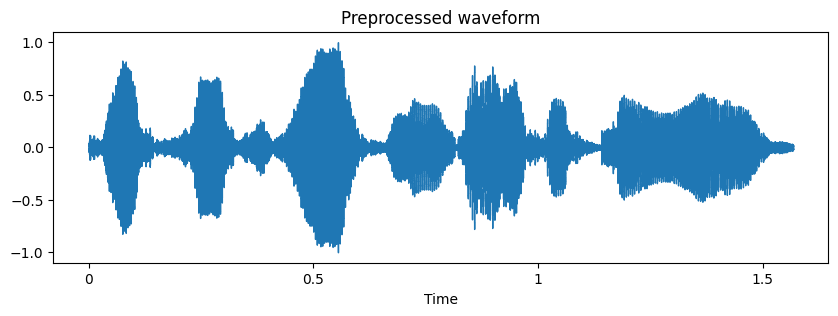

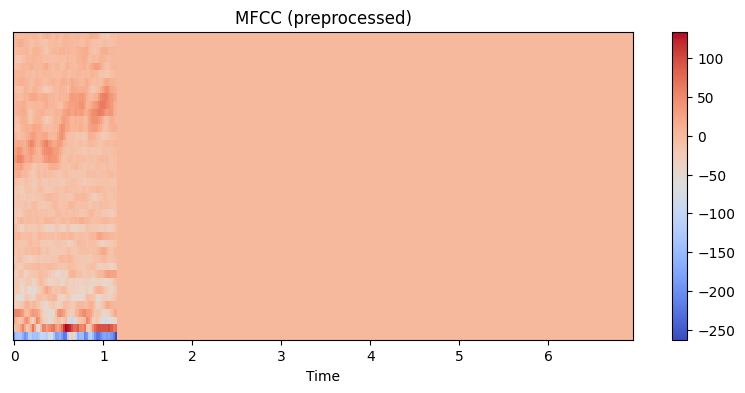

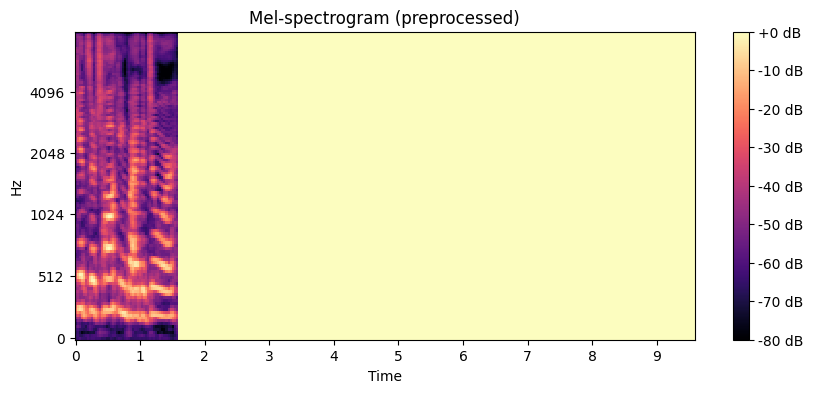

In [18]:
sample_path = df.iloc[0]['file_path']  # use your dataframe
print("Sample:", sample_path)

# preprocess-only (denoise False for speed)
y_pre, sr = preprocess_audio(sample_path, sr=16000, normalize=True, trim=True, denoise=False)
print("Waveform length:", len(y_pre), "sr:", sr)

# plot waveform (after preprocess)
plt.figure(figsize=(10,3))
librosa.display.waveshow(y_pre, sr=sr)
plt.title("Preprocessed waveform")
plt.show()

# show MFCC
mfcc = extract_mfcc_from_path(sample_path, n_mfcc=40, max_len=300, preprocess_cfg={'sr':16000,'normalize':True,'trim':True,'top_db':20,'denoise':False}, augment=False)
plt.figure(figsize=(10,4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title("MFCC (preprocessed)")
plt.show()

# show mel-spectrogram
mel = extract_mel_from_path(sample_path, n_mels=128, max_len=300, preprocess_cfg={'sr':16000,'normalize':True,'trim':True,'top_db':20,'denoise':False}, augment=False)
plt.figure(figsize=(10,4))
librosa.display.specshow(mel, x_axis='time', y_axis='mel', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title("Mel-spectrogram (preprocessed)")
plt.show()


# **batch extract MFCCs and save**

In [19]:
# Choose parameters
n_mfcc = 40
max_len = 300
pre_cfg = {'sr':16000, 'normalize':True, 'trim':True, 'top_db':20, 'denoise':False}

X = []
y = []
paths = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        mf = extract_mfcc_from_path(row['file_path'], n_mfcc=n_mfcc, max_len=max_len, preprocess_cfg=pre_cfg, augment=False)
        X.append(mf)
        y.append(row['emotion'])
        paths.append(row['file_path'])
    except Exception as e:
        print("Failed:", row['file_path'], e)

X = np.array(X)        # shape (N, n_mfcc, max_len)
y = np.array(y)
paths = np.array(paths)

# save to disk (re-loadable)
np.save("X_mfcc_preproc.npy", X)
np.save("y_labels.npy", y)
np.save("file_paths.npy", paths)
print("Saved X_mfcc_preproc.npy:", X.shape)



100%|██████████| 11682/11682 [01:55<00:00, 100.81it/s]


Saved X_mfcc_preproc.npy: (11682, 40, 300)


# **Count samples per emotion***

/tmp/ipython-input-1079455785.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="viridis")


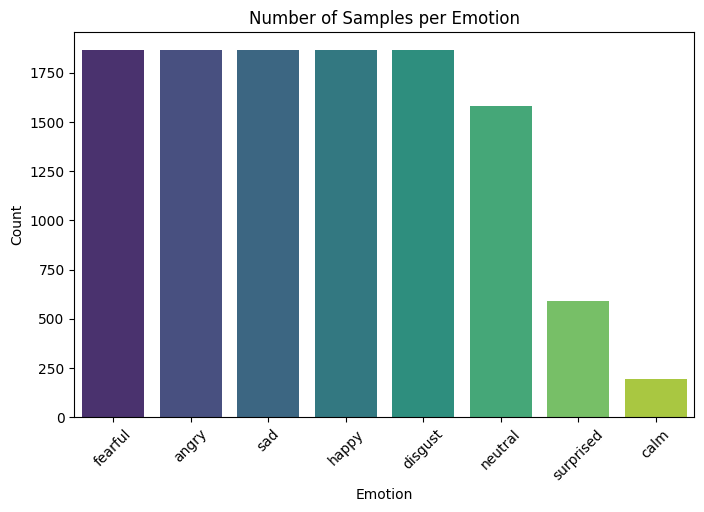

emotion
fearful      1863
angry        1863
sad          1863
happy        1863
disgust      1863
neutral      1583
surprised     592
calm          192
Name: count, dtype: int64


In [20]:

emotion_counts = df["emotion"].value_counts()

plt.figure(figsize=(8,5))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="viridis")
plt.title("Number of Samples per Emotion")
plt.ylabel("Count")
plt.xlabel("Emotion")
plt.xticks(rotation=45)
plt.show()

print(emotion_counts)


# **Plot Waveform**

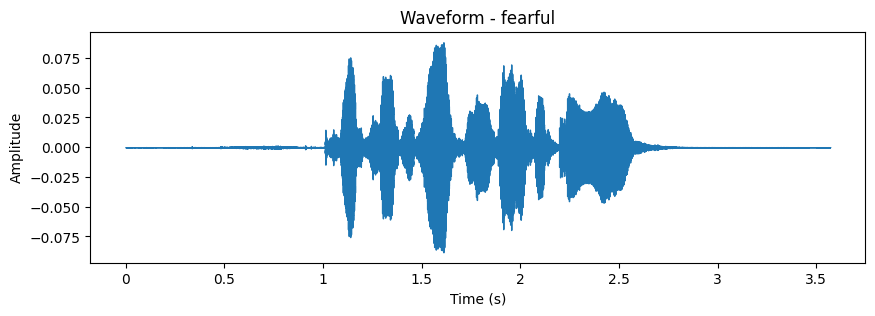

In [21]:

file = df.iloc[0]["file_path"]
audio, sr = librosa.load(file, sr=None)

plt.figure(figsize=(10, 3))
librosa.display.waveshow(audio, sr=sr)
plt.title(f"Waveform - {df.iloc[0]['emotion']}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


# **Plot MFCCs**

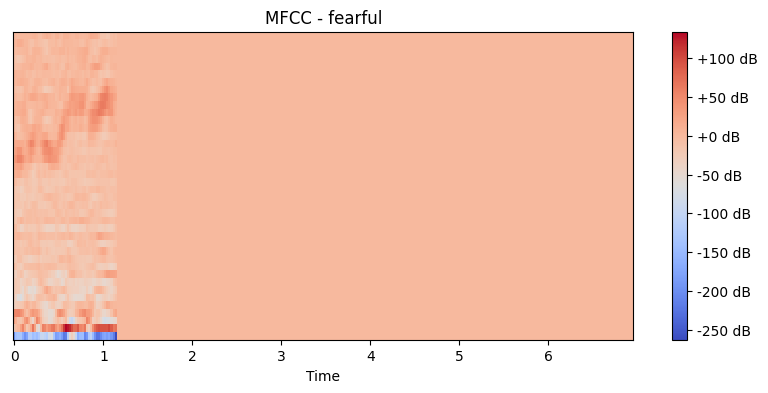

In [22]:
mfcc = extract_mfcc_from_path(file)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title(f"MFCC - {df.iloc[0]['emotion']}")
plt.show()


# **Plot Mel-Spectrogram**

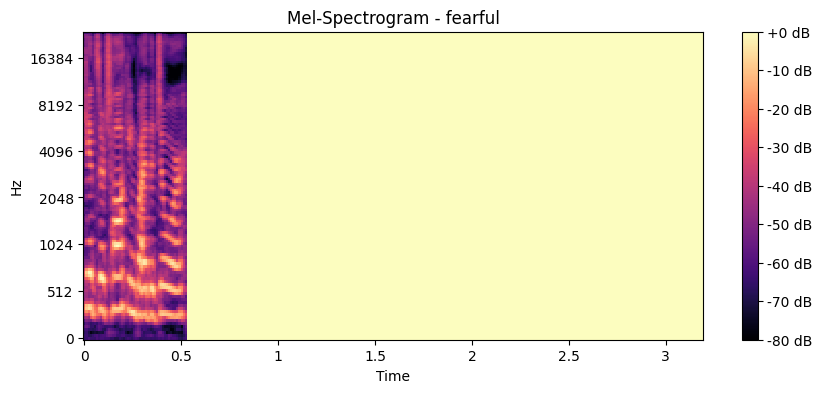

In [23]:
mel = extract_mel_from_path(file)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel, x_axis='time', y_axis='mel', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title(f"Mel-Spectrogram - {df.iloc[0]['emotion']}")
plt.show()


# **Compare Different Emotions**

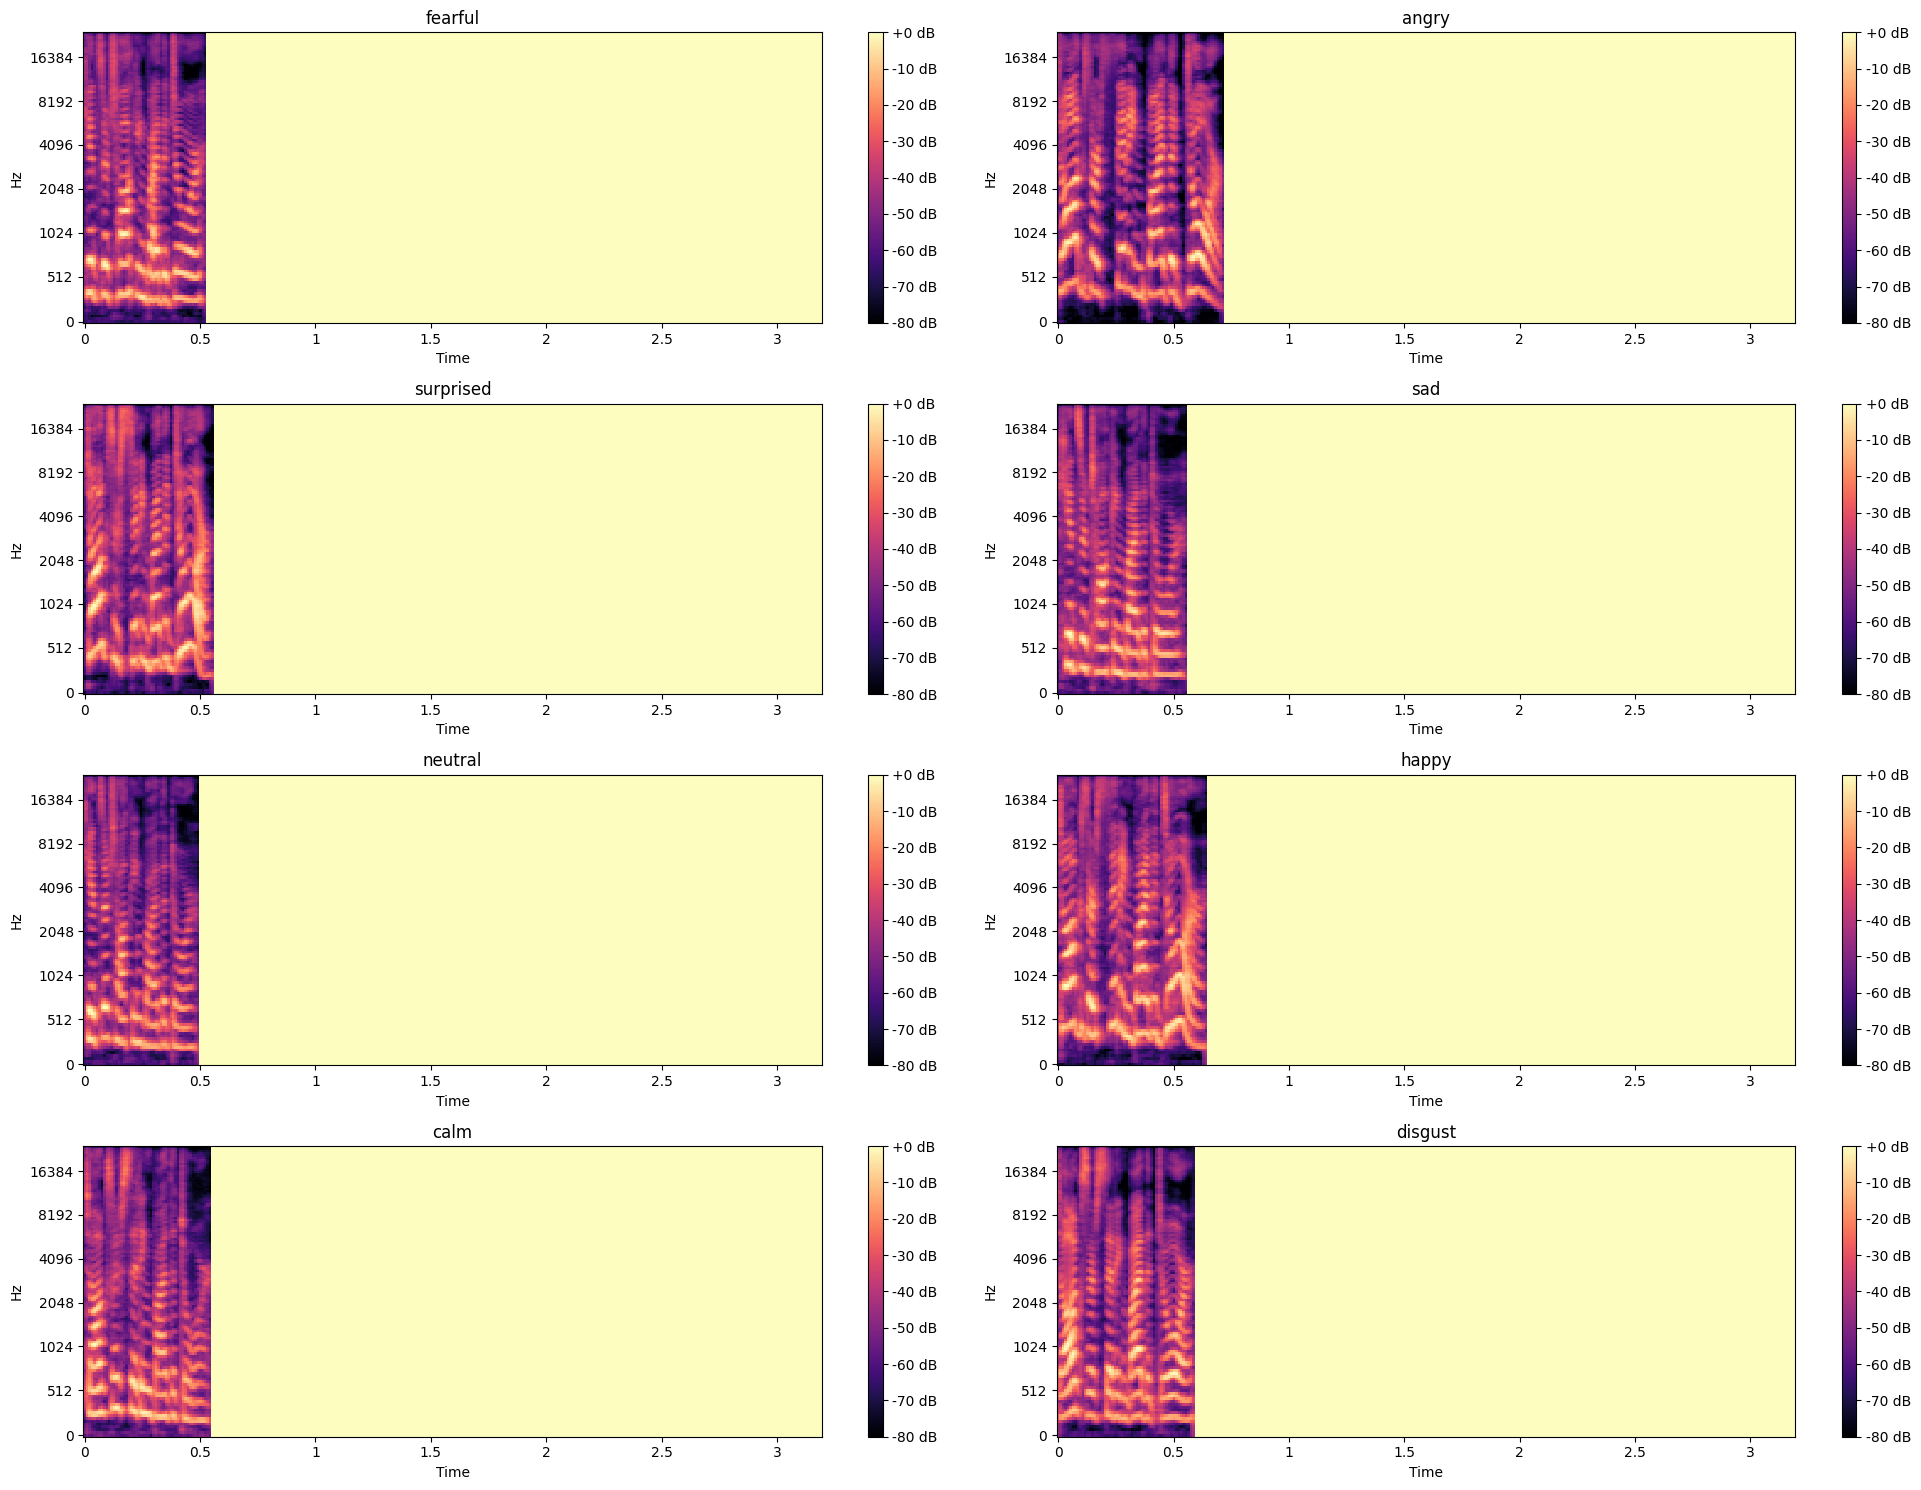

In [24]:
emotions_to_plot = df["emotion"].unique()[:8]  # first 4 emotions for example

plt.figure(figsize=(20, 15))

for i, emo in enumerate(emotions_to_plot, 1):
    sample_file = df[df["emotion"] == emo].iloc[0]["file_path"]
    mel = extract_mel_from_path(sample_file)

    plt.subplot(4, 2, i)
    librosa.display.specshow(mel, x_axis='time', y_axis='mel', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title(emo)

plt.tight_layout()
plt.show()


In [25]:
df

,file_path,emotion,dataset
0,./data/ravdess/audio_speech_actors_01-24/Actor...,fearful,ravdess
1,./data/ravdess/audio_speech_actors_01-24/Actor...,angry,ravdess
2,./data/ravdess/audio_speech_actors_01-24/Actor...,surprised,ravdess
3,./data/ravdess/audio_speech_actors_01-24/Actor...,sad,ravdess
4,./data/ravdess/audio_speech_actors_01-24/Actor...,neutral,ravdess
...,...,...,...
11677,./data/tess/TESS Toronto emotional speech set ...,sad,tess
11678,./data/tess/TESS Toronto emotional speech set ...,sad,tess
11679,./data/tess/TESS Toronto emotional speech set ...,sad,tess
11680,./data/tess/TESS Toronto emotional speech set ...,sad,tess


# **on-the-fly data generator for training (with augmentation)**

In [45]:
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
labels_enc = label_encoder.fit_transform(df['emotion'])
# (Save encoder for later: you can pickle label_encoder)

class AudioDataGenerator(Sequence):
    def __init__(self, df, batch_size=32, n_mfcc=40, max_len=300, preprocess_cfg=None, shuffle=True, augment_prob=0.5):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.n_mfcc = n_mfcc
        self.max_len = max_len
        self.preprocess_cfg = preprocess_cfg or {'sr':16000, 'normalize':True, 'trim':True, 'top_db':20, 'denoise':False}
        self.shuffle = shuffle
        self.augment_prob = augment_prob
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch_df = self.df.iloc[idx*self.batch_size : (idx+1)*self.batch_size]
        X_batch = []
        y_batch = []
        for _, row in batch_df.iterrows():
            do_aug = (np.random.rand() < self.augment_prob)
            mf = extract_mfcc_from_path(row['file_path'],
                                       n_mfcc=self.n_mfcc,
                                       max_len=self.max_len,
                                       preprocess_cfg=self.preprocess_cfg,
                                       augment=do_aug)
            X_batch.append(mf[..., np.newaxis])  # channel dim
            y_batch.append(row['emotion'])
        X_batch = np.array(X_batch)
        y_idx = label_encoder.transform(y_batch)
        y_cat = to_categorical(y_idx, num_classes=len(label_encoder.classes_))
        return X_batch, y_cat

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


# **Encode Labels**

In [27]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

print("Classes:", encoder.classes_)
print("y_encoded sample:", y_encoded[:10])


Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
y_encoded sample: [3 0 7 6 5 6 7 4 0 1]


In [46]:
lens = []
for p in df['file_path'].sample(500, random_state=42):
    y, sr = librosa.load(p, sr=16000)
    mf = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    lens.append(mf.shape[1])
max_len = int(np.percentile(lens, 95))
print("Suggested max_len:", max_len)


Suggested max_len: 117


# **Train/Test Split**

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Train shape: (9345, 40, 300)  Test shape: (2337, 40, 300)


In [47]:
from sklearn.model_selection import train_test_split



df_train, df_val = train_test_split(df, test_size=0.2, stratify=df['emotion'], random_state=42)

print("Train samples:", len(df_train))
print("Validation samples:", len(df_val))


Train samples: 9345
Validation samples: 2337


# **Reshape for CNN**

In [27]:
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print("Reshaped Train:", X_train.shape)


Reshaped Train: (9345, 40, 300, 1)


In [48]:
# Config
n_mfcc = 40

pre_cfg = {'sr':16000, 'normalize':True, 'trim':True, 'top_db':20, 'denoise':False}

train_gen = AudioDataGenerator(df_train, batch_size=32, n_mfcc=n_mfcc, max_len=max_len,
                               preprocess_cfg=pre_cfg, augment_prob=0.5)
val_gen   = AudioDataGenerator(df_val, batch_size=32, n_mfcc=n_mfcc, max_len=max_len,
                               preprocess_cfg=pre_cfg, augment_prob=0.0)

num_classes = len(label_encoder.classes_)
print("Classes:", label_encoder.classes_)

Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [40]:
# This cell is no longer needed as num_classes is defined in the model cell.

# **CNN Model**

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(n_mfcc, max_len, 1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 38, 115, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 38, 115, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 19, 57, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 17, 55, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 17, 55, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 8, 27, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 13824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │     1,769,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,789,832 (6.83 MB)

 Trainable params: 1,789,640 (6.83 MB)

 Non-trainable params: 192 (768.00 B)

# **Train**

In [51]:
history_cnn = cnn_model.fit(train_gen, validation_data=val_gen, epochs=20, verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.2371 - loss: 2.7209

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


293/293 ━━━━━━━━━━━━━━━━━━━━ 190s 631ms/step - accuracy: 0.2372 - loss: 2.7186 - val_accuracy: 0.3492 - val_loss: 1.5895
Epoch 2/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 179s 611ms/step - accuracy: 0.3025 - loss: 1.7237 - val_accuracy: 0.4108 - val_loss: 1.4839
Epoch 3/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 222s 680ms/step - accuracy: 0.3301 - loss: 1.6634 - val_accuracy: 0.4031 - val_loss: 1.4308
Epoch 4/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 179s 610ms/step - accuracy: 0.3507 - loss: 1.6029 - val_accuracy: 0.4176 - val_loss: 1.4515
Epoch 5/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 180s 613ms/step - accuracy: 0.3535 - loss: 1.5662 - val_accuracy: 0.4343 - val_loss: 1.3666
Epoch 6/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 219s 673ms/step - accuracy: 0.3947 - loss: 1.4868 - val_accuracy: 0.4745 - val_loss: 1.3265
Epoch 7/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 196s 669ms/step - accuracy: 0.4191 - loss: 1.4561 - val_accuracy: 0.5242 - val_loss: 1.2401
Epoch 8/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 175s 593ms/step - accuracy: 0.4117 - loss: 1.43

# **Evaluate**

In [52]:
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"✅ Test Accuracy: {test_acc:.4f}")

NameError: name 'model' is not defined

# **Plot Training Curves**

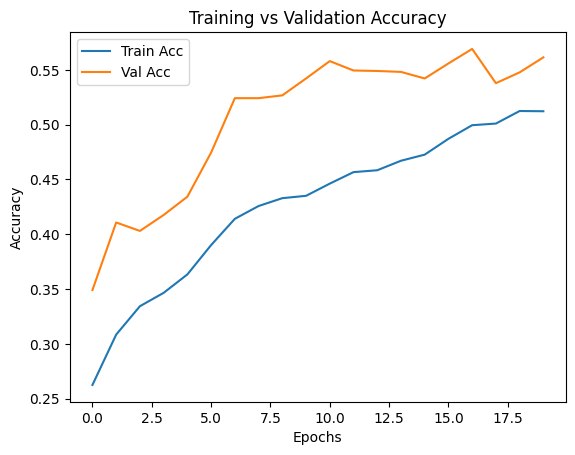

In [53]:
plt.plot(history_cnn.history['accuracy'], label='Train Acc')
plt.plot(history_cnn.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

# **Reshape Data for LSTM**

In [33]:
# Reshape: (samples, timesteps, features)
X_train_lstm = np.transpose(X_train.squeeze(), (0, 2, 1))
X_test_lstm = np.transpose(X_test.squeeze(), (0, 2, 1))

print("LSTM input shape:", X_train_lstm.shape)  # (samples, max_len, n_mfcc)


LSTM input shape: (9345, 300, 40)


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

model_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(128),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 300, 128)       │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 300, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 300, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,680 (924.53 KB)

 Trainable params: 236,168 (922.53 KB)

 Non-trainable params: 512 (2.00 KB)

In [35]:
history_lstm = model_lstm.fit(
    X_train_lstm, y_train_cat,
    validation_data=(X_test_lstm, y_test_cat),
    epochs=30,
    batch_size=32,
    verbose=1
)


Epoch 1/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.1572 - loss: 2.1341 - val_accuracy: 0.1596 - val_loss: 1.9665
Epoch 2/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.1607 - loss: 1.9767 - val_accuracy: 0.1596 - val_loss: 1.9872
Epoch 3/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.1576 - loss: 1.9784 - val_accuracy: 0.1596 - val_loss: 2.0423
Epoch 4/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.1659 - loss: 1.9578 - val_accuracy: 0.1596 - val_loss: 2.1260
Epoch 5/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.1485 - loss: 1.9672 - val_accuracy: 0.1596 - val_loss: 2.1970
Epoch 6/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.1604 - loss: 1.9630 - val_accuracy: 0.1596 - val_loss: 1.9552
Epoch 7/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.1633 - loss: 1.9573 - val_accuracy: 0.1596 - val_loss: 1.9595
Epoch 8/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.1573 - loss: 1.9628 - 

Epoch 29/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.6854 - loss: 0.8385 - val_accuracy: 0.6264 - val_loss: 1.0104
Epoch 30/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.6756 - loss: 0.8496 - val_accuracy: 0.6145 - val_loss: 1.0797

# **Evaluate**

In [36]:
test_loss, test_acc = model_lstm.evaluate(X_test_lstm, y_test_cat, verbose=0)
print(f"✅ LSTM Test Accuracy: {test_acc:.4f}")


✅ LSTM Test Accuracy: 0.1596


# **Plot Accuracy**

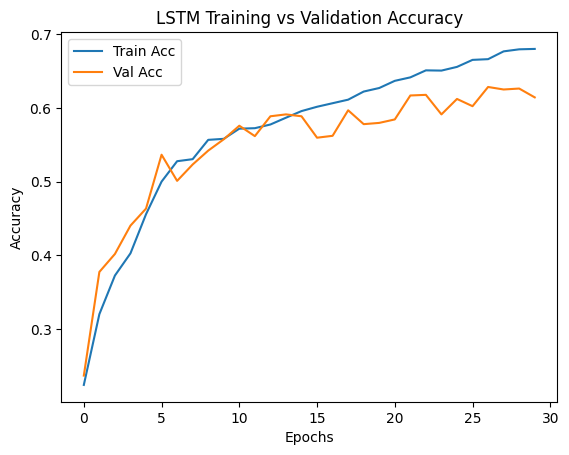

In [ ]:


plt.plot(history_lstm.history['accuracy'], label='Train Acc')
plt.plot(history_lstm.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("LSTM Training vs Validation Accuracy")
plt.show()


# **Reshape Data**

In [37]:
# Prepare input for CNN+LSTM
# Shape: (samples, n_mfcc, max_len, 1) for CNN
X_train_cnnlstm = X_train
X_test_cnnlstm = X_test
print("CNN+LSTM input shape:", X_train_cnnlstm.shape)


CNN+LSTM input shape: (9345, 40, 300, 1)


# **CNN + LSTM Model**

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, TimeDistributed, Flatten
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

model_cnn_lstm = Sequential([
    # CNN Layers
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=X_train_cnnlstm.shape[1:]),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Dropout(0.3),

    # Keep time steps: Flatten per frame
    TimeDistributed(Flatten()),

    # LSTM Layers
    LSTM(128, return_sequences=True),
    Dropout(0.3),

    LSTM(128),
    Dropout(0.3),

    # Fully Connected Layers
    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

model_cnn_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_lstm.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 40, 300, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 40, 300, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 20, 150, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 20, 150, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 20, 150, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 4800)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 128)        │     2,523,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,691,976 (10.27 MB)

 Trainable params: 2,691,784 (10.27 MB)

 Non-trainable params: 192 (768.00 B)

# **Train**

In [39]:
history_cnnlstm = model_cnn_lstm.fit(
    X_train_cnnlstm, y_train_cat,
    validation_data=(X_test_cnnlstm, y_test_cat),
    epochs=30,
    batch_size=32,
    verbose=1
)


Epoch 1/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.2582 - loss: 1.8072 - val_accuracy: 0.4579 - val_loss: 1.3540
Epoch 2/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.4475 - loss: 1.4023 - val_accuracy: 0.5349 - val_loss: 1.1888
Epoch 3/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.5004 - loss: 1.2531 - val_accuracy: 0.5486 - val_loss: 1.1273
Epoch 4/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.5347 - loss: 1.1718 - val_accuracy: 0.5588 - val_loss: 1.0999
Epoch 5/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.5563 - loss: 1.1270 - val_accuracy: 0.5618 - val_loss: 1.1042
Epoch 6/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.5824 - loss: 1.0722 - val_accuracy: 0.6008 - val_loss: 1.0190
Epoch 7/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.5729 - loss: 1.0890 - val_accuracy: 0.5884 - val_loss: 1.0207
Epoch 8/30
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.6009 - loss: 1.0358 - 

# **Evaluate**

In [ ]:
test_loss, test_acc = model_cnn_lstm.evaluate(X_test_cnnlstm, y_test_cat, verbose=0)
print(f"✅ CNN+LSTM Test Accuracy: {test_acc:.4f}")

✅ CNN+LSTM Test Accuracy: 0.6256


# **Training Curves**

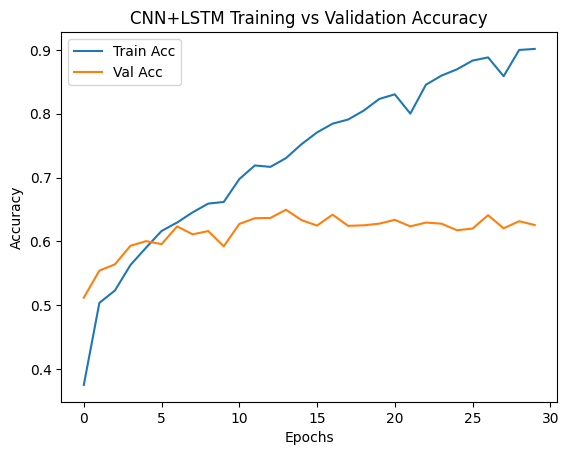

In [ ]:


plt.plot(history_cnnlstm.history['accuracy'], label='Train Acc')
plt.plot(history_cnnlstm.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("CNN+LSTM Training vs Validation Accuracy")
plt.show()
